In [1]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

In [2]:
START_DATE = '2003-3-31'
END_DATE = '2024-3-31'

# 台股個別分析 (?)

### 回測期間 - 2003/3/31  ~ 2009/3/31 

## import

In [3]:
import talib
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import plotly.graph_objs as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta



from dataframe import CustomDataFrame

import plot_data

## get data

In [4]:
data=Data()

---

## 資料下載

### **盈餘再投資率**

In [5]:
profit = data.get('annual_report_fundamentals:常續性稅後淨利')

In [6]:
# plot_data.numeric_bins(profit, "稅後淨利逐年數值分佈", stacked=True, num_label=True,
#                 bins=[-np.inf, 0, 500000, np.inf], 
#                 labels=['負值', '0~5億', '5億以上'])

In [7]:
# 抓資料
long_term_items = [
    '透過損益按公允價值衡量之金融資產－非流動', #2005
    '透過其他綜合損益按公允價值衡量之金融資產－非流動', #2005
    '按攤銷後成本衡量之金融資產－非流動', #2005
    '避險之金融資產－非流動', #2005
    '合約資產－非流動', #2017
    '採權益法之長期股權投資',
    '預付投資款', #2005
    '投資性不動產淨額'
]

# 長期投資項目 (8個)
long_term_data = [data.get(f'annual_report_fundamentals:{item}').fillna(0) for item in long_term_items]
long_term_investment = sum(long_term_data)
# 固定資產
fixed_assets_year = data.get('annual_report_fundamentals:不動產廠房及設備').fillna(0)

In [8]:
rr_sum = data.get('annual_report_fundamentals:非流動資產') #.fillna(0)

In [9]:
# rr_sum

In [10]:
rr_sum_df = rr_sum - rr_sum.shift(4)

In [11]:
# test = data.get('annual_report_fundamentals:不動產廠房及設備')
# test.notna().sum(axis=1).plot()

In [12]:
# 計算盈再率分子
long_term_investment_df = (long_term_investment - long_term_investment.shift(4))
fixed_assets_df = (fixed_assets_year - fixed_assets_year.shift(4))

In [13]:
profit_rol_df = profit.rolling(4).sum()

In [14]:
# 計算出盈再率
# 去掉淨利為負的公司 (當年度淨利為負、四年加總淨利為負都去掉)
orig_rr = (long_term_investment_df + fixed_assets_df) / profit_rol_df
orig_rr = orig_rr[(profit > 0) & (profit_rol_df > 0)]['2009':]

old_rr = rr_sum_df / profit_rol_df
old_rr = old_rr[(profit > 0) & (profit_rol_df > 0)][:'2008']

common_columns = sorted(list(set(orig_rr.columns) & set(old_rr.columns)))
# 合併資料
rr = pd.concat([old_rr[common_columns], orig_rr[common_columns]])

rr

company_symbol,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
1994-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-31,8.300768,1.245832,3.717276,0.987052,-0.193206,0.282010,1.848552,NaN,NaN,4.410958,...,1.109336,NaN,NaN,NaN,0.729640,NaN,NaN,1.272429,NaN,NaN
1999-03-31,10.361118,0.993799,NaN,0.149234,-0.776421,0.267587,2.146137,NaN,NaN,3.803985,...,-0.085216,NaN,NaN,NaN,NaN,3.076410,NaN,1.930809,NaN,NaN
2000-03-31,13.744968,1.177991,NaN,-0.655417,-0.891752,0.114323,2.759842,NaN,NaN,1.642418,...,0.247863,NaN,NaN,0.263192,4.881643,4.141837,NaN,0.508218,NaN,8.098450
2001-03-31,NaN,0.981544,NaN,0.170908,NaN,0.448240,NaN,NaN,NaN,1.369873,...,0.385548,NaN,2.814245,0.316606,NaN,2.422758,2.878287,0.330014,NaN,3.213813
2002-03-31,NaN,1.529271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.115576,...,1.089505,NaN,0.128580,0.284576,43.498054,1.510449,2.711080,NaN,NaN,-0.555858
2003-03-31,NaN,3.005175,NaN,25.807640,NaN,0.459786,5.507610,NaN,NaN,0.804104,...,1.266114,NaN,0.298512,0.369946,2.311996,0.687961,1.202436,NaN,NaN,-0.593396


### 盈再率 - 數值分佈

In [15]:
# plot_data.numeric_bins(rr, "盈餘再投資率逐年數值分佈", stacked=True, num_label=True,
#                 bins=[-np.inf, 0, 0.40, 0.80, 1.20, 1.60, 2.00, 2.40, 2.80, 3.20, np.inf], 
#                 labels=['負值' ,'0-40%', '40-80%', '80-120%', '120-160%', '160-200%', '200-240%', '240-280%', '280-320%', '320%以上'])

---

### **本益比 (P/E)**
- 每季資料
- 每日資料

In [16]:
pe = data.get('quarter_report:PE') #[START_DATE:END_DATE]
daily_pe = data.get('price:daily_pe') #[START_DATE:END_DATE]

### **其他因子**

- ROE (季資料，取第四季)
- 股利支付率 (只有年資料) ＝〈現金股利總額〈元〉／ 股利分配年度之稅後淨利〉x 100
- 董監持股 (沒有每年的資料，缺值採向前補值)
- 上市上櫃滿兩年

In [17]:
roe = data.get('annual_report:ROE')
payout_ratio = data.get('annual_report_fundamentals:股利支付率')

In [18]:
stock_hold = data.get('annual_report_fundamentals:董監持股%')

In [19]:
# listed_date = pd.read_csv('../2024_code/最近上市日.csv', encoding='cp950')

##### 上市上櫃滿兩年

In [20]:
close = data.get('price:close')
comp_profile = data.get('company_profile')



stock_data = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date_ = row['ipo_date']
    end_date = listed_date_ + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed = pd.concat(stock_data, axis=1)

---

## 選股條件
- ROE 五年平均 > 15%
- 盈再率 < 80%
- 稅後淨利 > 五億
- 配息 > 40%
- 董監持股 > 10%
- 上市上櫃滿兩年
- PE < 12買入，>30賣出

In [21]:
# ROE 5年平均 > 15%
roe_rol = roe.rolling(5).mean()
roe_15 = (roe_rol > 15)

In [22]:
rr_cond = (rr < 0.4)

In [23]:
# *最近3年的配息率有無一年不及40%*
payout_ratio_cond = (payout_ratio.rolling(3).min() >= 40)

# # 金融股看配息率，不看盈再率
# rr_cond[finance_stock_list] = payout_ratio_cond[finance_stock_list]

In [24]:
# 淨利 > 5億
profit_cond = (profit > 500000) # TEJ 的淨利單位是千元

In [25]:
hold_cond = stock_hold > 10

In [26]:
listed = listed.resample('M').last()

---

---

## 原始條件 + 無本益比進出場條件

In [27]:
orig_all_cond = roe_15 & rr_cond & payout_ratio_cond & profit_cond & hold_cond & listed

---

## 原始條件 + 有本益比進出場

### 每季本益比進出場

In [28]:
# (每季)本益比條件

pe_cond_entry = pe < 12
pe_cond_exit = pe > 30

In [29]:
orig_all_cond_and_pe = (orig_all_cond[START_DATE:END_DATE] & pe_cond_entry[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit[START_DATE:END_DATE])

### **每月本益比進出場**

In [30]:
# 每日本益比resample成每月
daily_pe_resample = daily_pe.resample('M').last()

pe_cond_entry_daily = daily_pe_resample < 12
pe_cond_exit_daily = daily_pe_resample > 30

In [31]:
orig_all_cond_and_pe_daily = ((orig_all_cond[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE]))

# rep_all_cond_and_pe_daily = backtest.sim(orig_all_cond_and_pe_daily, resample='M', data=data)
# rep_all_cond_and_pe_daily.display()

In [32]:
# all_cond_pos_ret, all_cond_neg_ret = rep_all_cond_and_pe_daily.calc_returns_contrib(5)

---

---

## 綜合比較入選股數變化

In [33]:
all_cond_reps = {}

all_cond_reps['原始條件_無本益比'] = orig_all_cond[START_DATE:END_DATE]
all_cond_reps['原始條件_無本益比_ROE出場條件'] = orig_all_cond[START_DATE:END_DATE] & (roe[START_DATE:END_DATE] > 15)
# all_cond_reps['原始條件_無本益比_布林通道'] = orig_all_cond[START_DATE:END_DATE] & bolling_1_filt[START_DATE:END_DATE]
# all_cond_reps['原始條件_無本益比_ROE出場條件_布林通道'] = orig_all_cond[START_DATE:END_DATE] & bolling_1_filt[START_DATE:END_DATE] & (roe[START_DATE:END_DATE] > 15)

# all_cond_reps['原始條件_每季本益比'] = orig_all_cond_and_pe[START_DATE:END_DATE]
all_cond_reps['原始條件_有本益比'] = orig_all_cond_and_pe_daily[START_DATE:END_DATE]
all_cond_reps['原始條件_有本益比_ROE出場條件'] = (orig_all_cond[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 15))
# all_cond_reps['原始條件_有本益比_布林通道'] = (orig_all_cond[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE] | ~bolling_1_filt[START_DATE:END_DATE])
# all_cond_reps['原始條件_有本益比_ROE出場條件_布林通道'] = (orig_all_cond[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE] | ~bolling_1_filt[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 15)) 


# all_cond_reps['原始條件_無本益比進出場_2009~2024'] = orig_all_cond['2009-3':'2024']
# all_cond_reps['原始條件_每季本益比_2009~2024'] = (orig_all_cond['2009-3':'2024'] & pe_cond_entry['2009-3':'2024']).hold_until((~orig_all_cond['2009-3':'2024']) | pe_cond_exit['2009-3':'2024'])
# all_cond_reps['原始條件_每日本益比_2009~2024'] = ((orig_all_cond['2009-3':'2024'] & pe_cond_entry_daily['2009-3':'2024']).hold_until((~orig_all_cond['2009-3':'2024']) | pe_cond_exit_daily['2009-3':'2024']))


rep_collecs = sim_conditions(all_cond_reps, resample='M', data=data)


# all_cond_reps_2003_09 = {}

# all_cond_reps_2003_09['原始條件_無本益比進出場_2003_09'] = orig_all_cond[START_DATE:END_DATE]
# all_cond_reps_2003_09['原始條件_每季本益比_2003_09'] = orig_all_cond_and_pe[START_DATE:END_DATE]
# all_cond_reps_2003_09['原始條件_每日本益比_2003_09'] = orig_all_cond_and_pe_daily[START_DATE:END_DATE]

# all_cond_reps_2009_24 = {}

# all_cond_reps_2009_24['原始條件_無本益比進出場_2009_24'] = orig_all_cond[2009:2024]
# all_cond_reps_2009_24['原始條件_每季本益比_2009_24'] = orig_all_cond_and_pe[2009:2024]
# all_cond_reps_2009_24['原始條件_每日本益比_2009_24'] = orig_all_cond_and_pe_daily[2009:2024]


# rep_collecs_2003_09 = sim_conditions(all_cond_reps_2003_09, resample='M', data=data)
# rep_collecs_2009_24 = sim_conditions(all_cond_reps_2009_24, resample='M', data=data)


Backtesting progress: 100%|██████████| 4/4 [00:07<00:00,  1.88s/condition]


In [34]:
rep_collecs.selected_stock_count_analysis()

,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
原始條件_有本益比_ROE出場條件,13.79,-55.20,29.13,31.0,23.0,37.0,1.0,56.0
原始條件_有本益比,13.66,-55.38,35.50,37.0,29.0,43.0,2.0,63.0
原始條件_無本益比_ROE出場條件,13.36,-55.34,46.43,46.0,39.0,59.0,2.0,88.0
原始條件_無本益比,12.77,-54.84,54.96,58.0,51.0,71.0,3.0,100.0


In [35]:
rep_collecs.reports['原始條件_有本益比_ROE出場條件'].display()

,annualized_rate_of_return,sharpe,max_drawdown,win_ratio
,13.79%,25.38,-55.2%,54.66%


,entry_date,exit_date,entry_sig_date,exit_sig_date,position,period,entry_index,exit_index,return,mae,gmfe,bmfe,mdd,pdays,weight,next_weights
stock_id,,,,,,,,,,,,,,,,
4952,2022-06-01,2023-12-01,2022-05-31,2023-11-30,0.019608,368,5554,5922,-0.192461,-4.411949e-01,0.009853,0.009853,-0.446647,1.0,0.000000,0.000000
8155,2023-04-06,2023-12-01,2023-03-31,2023-11-30,0.019231,164,5758,5922,0.216888,-1.550587e-02,0.445734,0.000000,-0.316674,160.0,0.000000,0.000000
2059,2023-04-06,2024-02-01,2023-03-31,2024-01-31,0.019231,207,5758,5965,1.822981,0.000000e+00,1.882445,0.000000,-0.310652,207.0,0.000000,0.000000
3131,2022-07-01,2024-02-01,2022-06-30,2024-01-31,0.018519,390,5575,5965,2.218605,-1.357639e-01,2.372183,0.426363,-0.394098,364.0,0.000000,0.000000
6669,2022-12-01,2024-02-01,2022-11-30,2024-01-31,0.018519,283,5682,5965,1.549821,-1.848925e-01,1.632221,0.058625,-0.354609,244.0,0.000000,0.000000
3324,2020-04-01,2024-03-01,2020-03-31,2024-02-29,0.028571,953,5025,5978,3.901533,0.000000e+00,3.907383,0.000000,-0.525168,953.0,0.000000,0.000000
1232,2010-05-03,NaT,2010-04-30,NaT,0.033333,3541,2582,-1,6.871704,-3.780169e-02,6.987364,0.000000,-0.286155,3503.0,0.022222,0.022222
1527,2023-04-06,NaT,2023-03-31,NaT,0.019231,365,5758,-1,0.212511,-5.471480e-02,0.248172,0.011642,-0.087372,186.0,0.022222,0.022222
1537,2013-05-02,NaT,2013-04-30,NaT,0.040000,2795,3328,-1,3.692059,-1.700017e-02,3.901485,0.000000,-0.299662,2791.0,0.022222,0.022222


In [36]:
# _,_=rep_collecs.reports['原始條件_有本益比'].calc_returns_contrib()

---

In [38]:
# plt.figure(figsize=(12, 6))

# # 完整資料
# x_full = close['2003':'2024-3'].index  # X 軸完整資料
# y_full = close['2003':'2024-3'].notna().sum(axis=1)  # Y 軸完整資料

# # Resample 的資料（每年三月底）
# x_resampled = close['2003':'2024-3'].resample('A-JAN').last().index  # Resample 的 X 軸
# y_resampled = close['2003':'2024-3'].notna().sum(axis=1).resample('A-JAN').last()  # Resample 的 Y 軸

# # 繪製完整資料的折線圖
# plt.plot(x_full, y_full, linestyle='-', linewidth=1, label='Daily Data')

# # 在 Resample 點添加 marker
# plt.plot(x_resampled, y_resampled, marker='o', linestyle='', markersize=3, color='tab:blue')

# # 為 Resample 點添加數字標籤
# for i, value in enumerate(y_resampled):
#     plt.text(x_resampled[i], y_resampled.iloc[i], str(value), ha='center', va='bottom', fontsize=8, color='black')

# # 設置標籤和樣式
# plt.xlabel("Year")
# plt.ylabel("公司家數")
# plt.title("2003~2024 台灣上市櫃公司數")
# plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
# plt.xticks(
#     ticks=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS"),
#     labels=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
#     rotation=45
# )

# # 顯示圖例
# plt.legend()
# plt.tight_layout()
# plt.show()


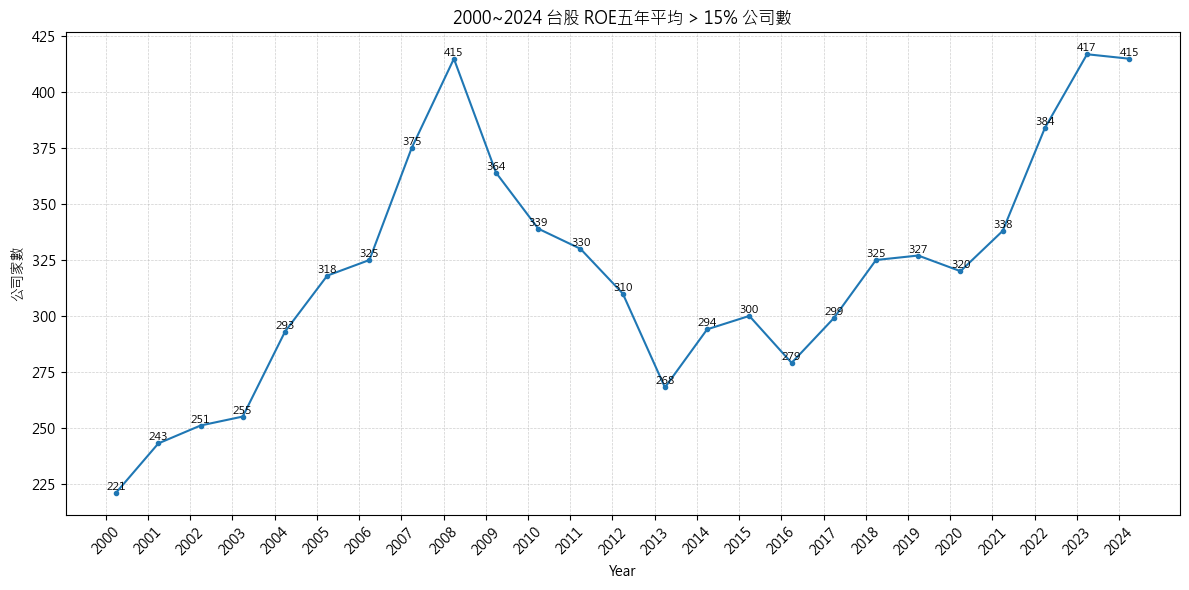

In [39]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = roe_15['2000':'2024-3']
x = plot_data.index  # X 軸
y = plot_data.sum(axis=1)  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2000~2024 台股 ROE五年平均 > 15% 公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


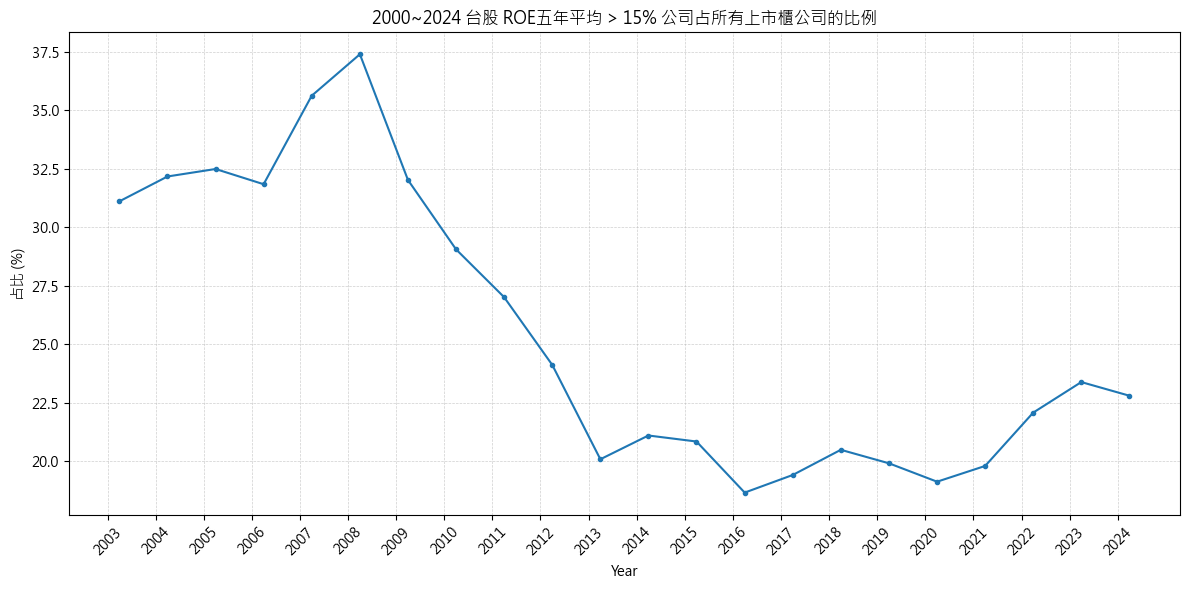

In [51]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = (roe_15['2003':'2024-3'].sum(axis=1) / close['2003':'2024-3'].notna().sum(axis=1).resample('A-MAR').last()) * 100
x = plot_data.index  # X 軸
y = plot_data #.sum(axis=1)  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("占比 (%)")
plt.title("2000~2024 台股 ROE五年平均 > 15% 公司占所有上市櫃公司的比例")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)


# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


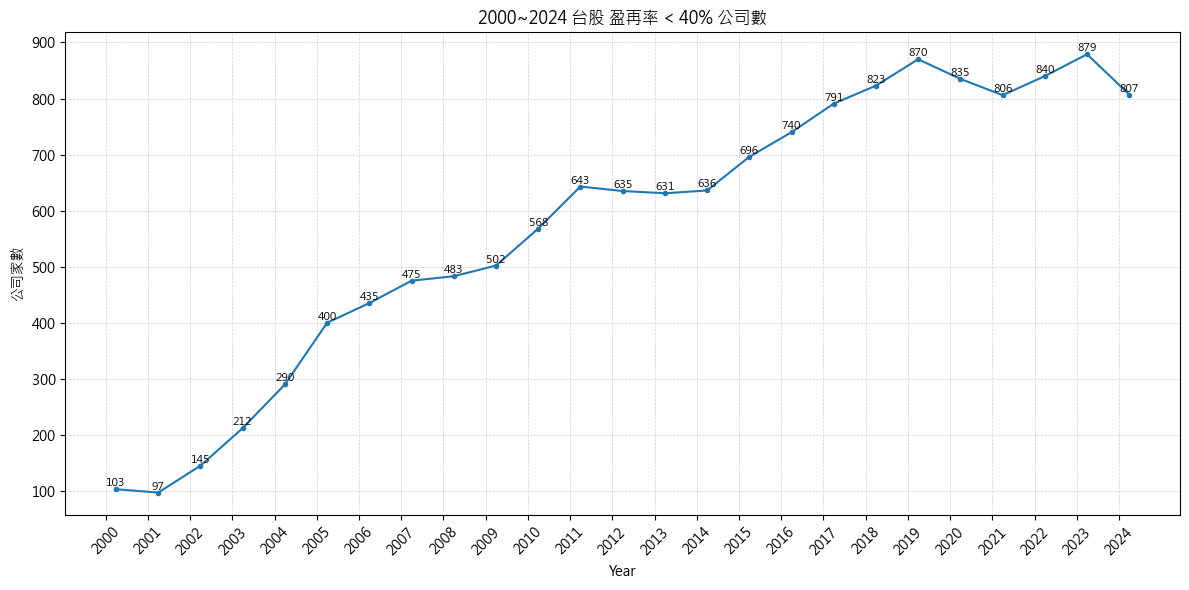

In [40]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = rr_cond['2000':'2024-3']
x = plot_data.index  # X 軸
y = plot_data.sum(axis=1)  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2000~2024 台股 盈再率 < 40% 公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


In [41]:
# rr[['2330']]

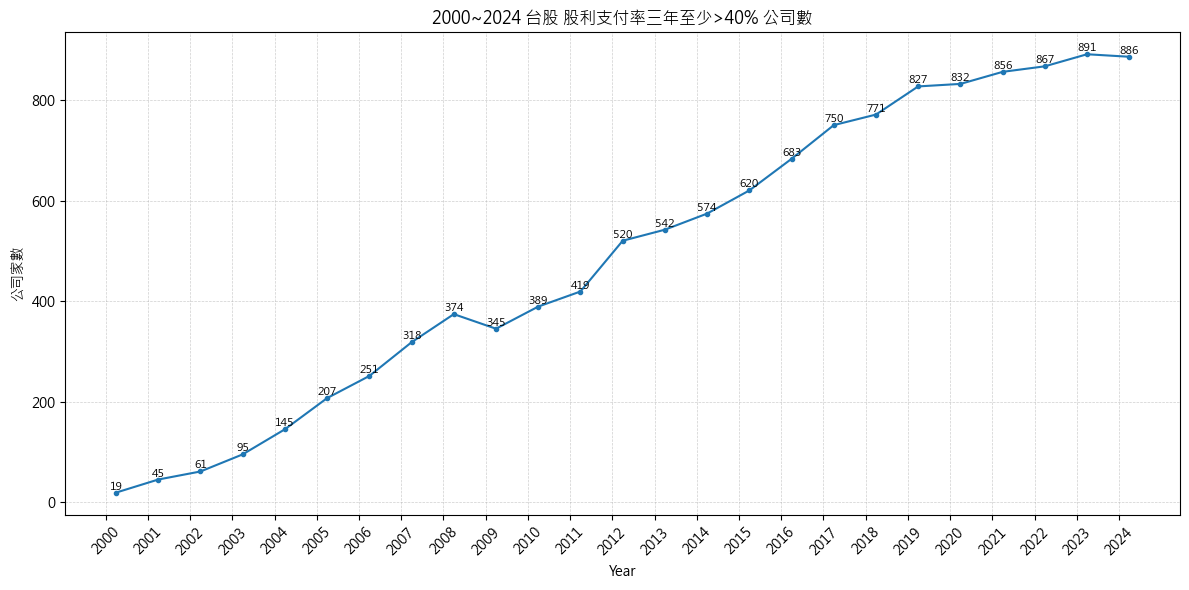

In [42]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = payout_ratio_cond['2000':'2024-3']
x = plot_data.index  # X 軸
y = plot_data.sum(axis=1)  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2000~2024 台股 股利支付率三年至少>40% 公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


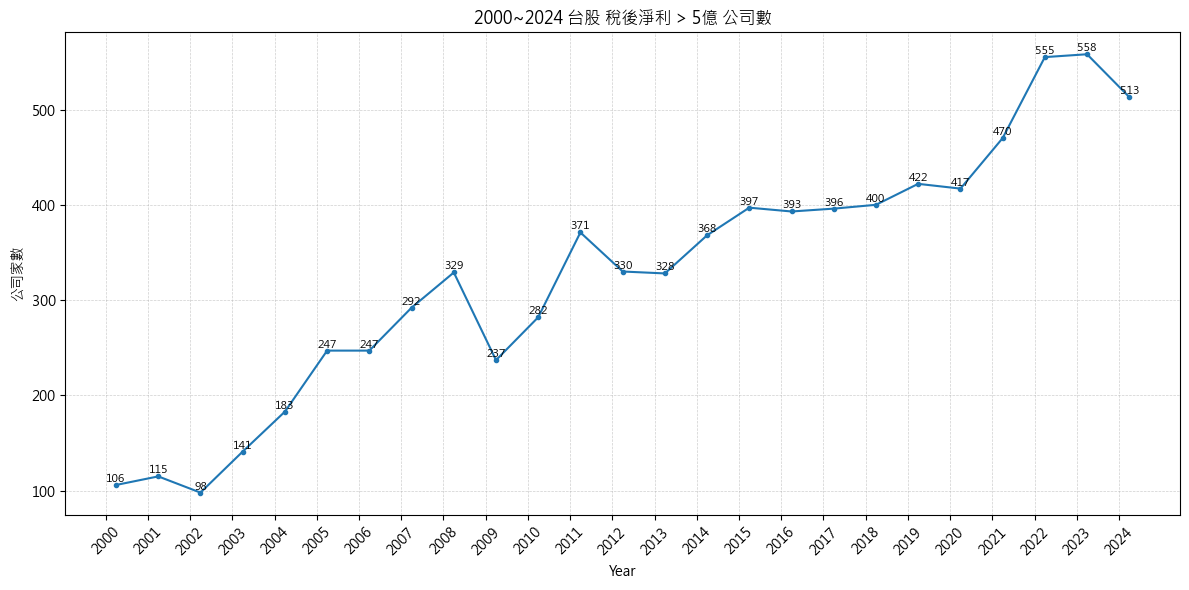

In [43]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = profit_cond['2000':'2024-3']
x = plot_data.index  # X 軸
y = plot_data.sum(axis=1)  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2000~2024 台股 稅後淨利 > 5億 公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


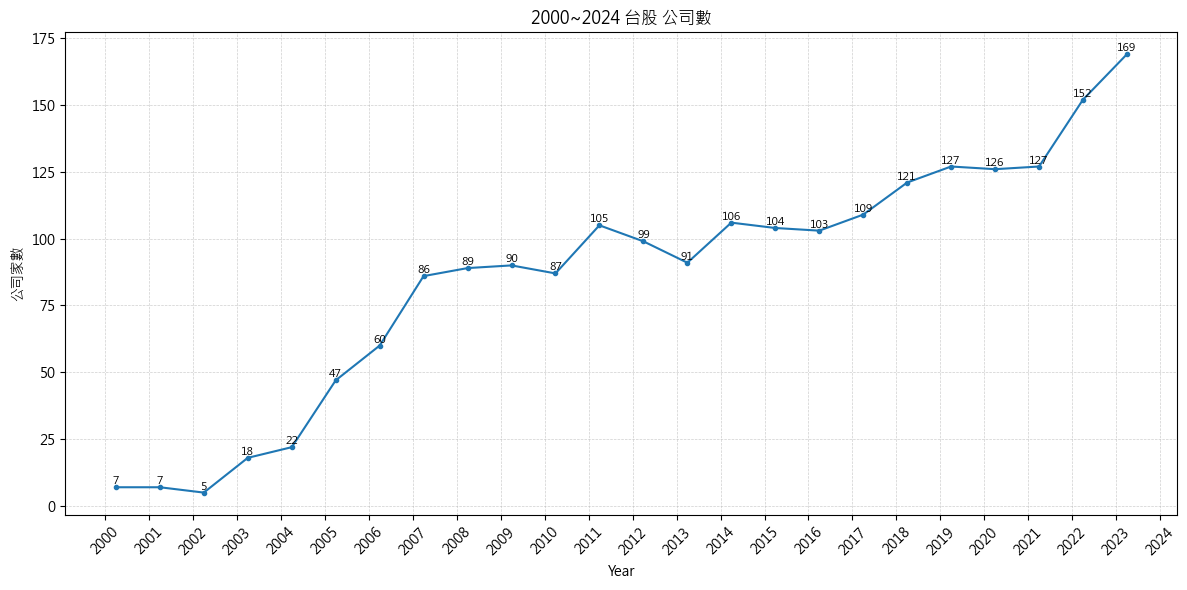

In [44]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = (rr_cond & roe_15 & profit_cond)['2000':'2023'] #& close.notna().resample('A-MAR').last()
x = plot_data.index  # X 軸
y = plot_data.sum(axis=1)  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2000~2024 台股 公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


In [90]:
for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date_ = row['ipo_date']
    end_date = listed_date_ # + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed_df = pd.concat(stock_data, axis=1).resample('M').last()

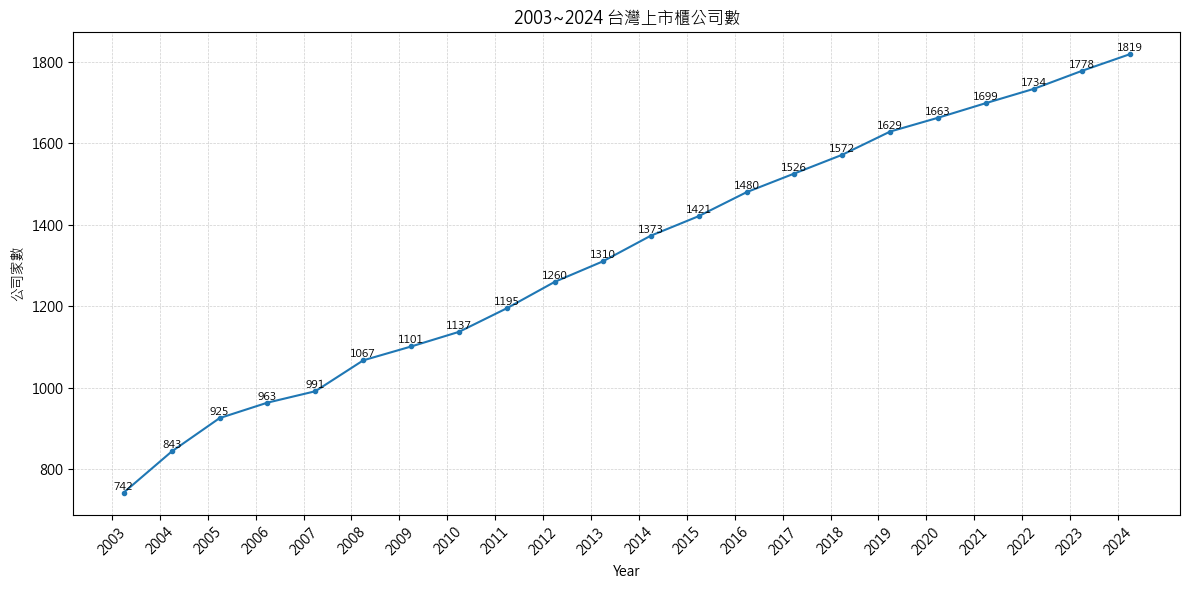

In [100]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = pd.concat(stock_data, axis=1)['2003':'2024-3']
x = plot_data.resample('A-MAR').last().index  # X 軸
y = plot_data.sum(axis=1).resample('A-MAR').last()  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2003~2024 台灣上市櫃公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


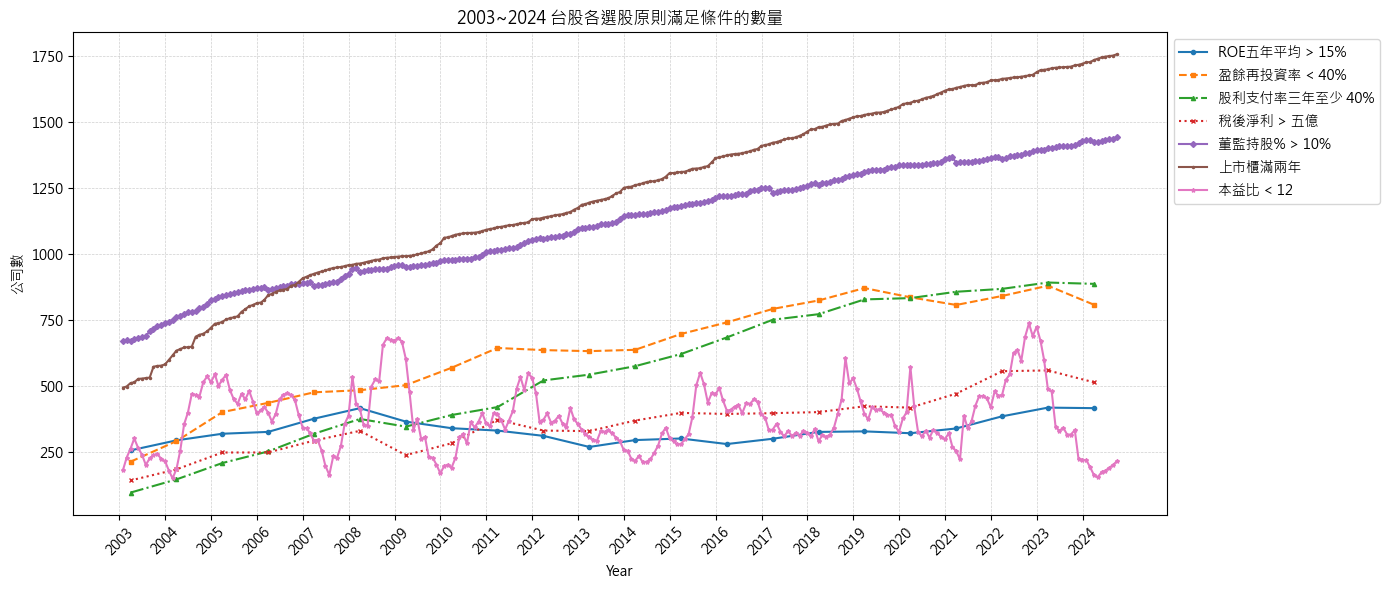

In [111]:
plt.figure(figsize=(14, 6))

# 準備資料
roe_data = roe_15['2003':'2024-9'].sum(axis=1)
rr_data = rr_cond['2003':'2024-9'].sum(axis=1)
payout_data = payout_ratio_cond['2003':'2024-9'].sum(axis=1)
profit_data = profit_cond['2003':'2024-9'].sum(axis=1)
# common_columns = hold_cond.columns.intersection(payout_ratio_cond.columns)
hold_cond_data = (hold_cond & listed_df)['2003':'2024-9'].sum(axis=1)
listed_data = listed['2003':'2024-9'].sum(axis=1)
pe_cond_entry_data = pe_cond_entry_daily['2003':'2024-9'].sum(axis=1)

# 繪製折線圖
plt.plot(roe_data.index, roe_data, marker='o', linestyle='-', markersize=3, label='ROE五年平均 > 15%')
plt.plot(rr_data.index, rr_data, marker='s', linestyle='--', markersize=3, label='盈餘再投資率 < 40%')
plt.plot(payout_data.index, payout_data, marker='^', linestyle='-.', markersize=3, label='股利支付率三年至少 40%')
plt.plot(profit_data.index, profit_data, marker='x', linestyle=':', markersize=3, label='稅後淨利 > 五億')
plt.plot(hold_cond_data.index, hold_cond_data, marker='D', linestyle='-', markersize=3, label='董監持股% > 10%')
plt.plot(listed_data.index, listed_data, marker='o', linestyle='-', markersize=1.5, label='上市櫃滿兩年')
plt.plot(pe_cond_entry_data.index, pe_cond_entry_data, marker='*', linestyle='-', markersize=3, label='本益比 < 12')

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司數")
plt.title("2003~2024 台股各選股原則滿足條件的數量")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 將圖例移動到圖表右上角外
plt.tight_layout()
plt.show()


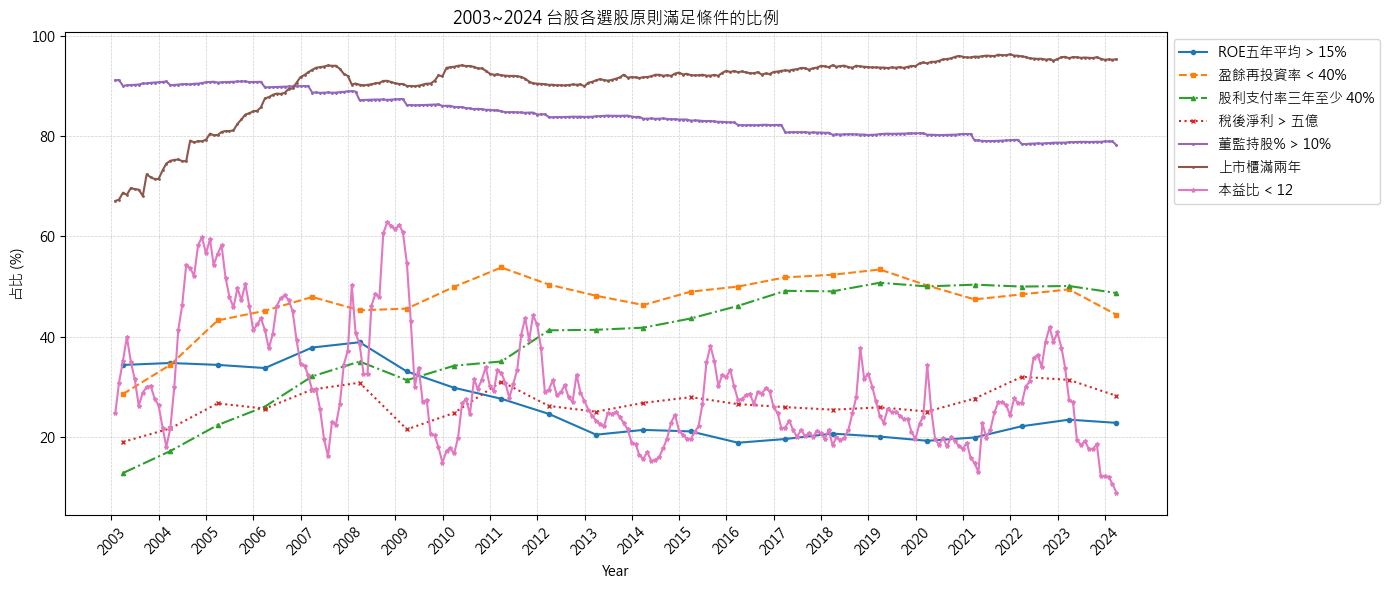

In [107]:
plt.figure(figsize=(14, 6))

# 準備資料
roe_data = (roe_15['2003':'2024-3'].sum(axis=1) / listed_df['2003':'2024-3'].sum(axis=1).resample('A-MAR').last()) * 100
rr_data = (rr_cond['2003':'2024-3'].sum(axis=1) / listed_df['2003':'2024-3'].sum(axis=1).resample('A-MAR').last()) * 100
payout_data = (payout_ratio_cond['2003':'2024-3'].sum(axis=1) / listed_df['2003':'2024-3'].sum(axis=1).resample('A-MAR').last()) * 100
profit_data = (profit_cond['2003':'2024-3'].sum(axis=1) / listed_df['2003':'2024-3'].sum(axis=1).resample('A-MAR').last()) * 100
# common_columns = hold_cond.columns.intersection(payout_ratio_cond.columns)
hold_cond_data = ((hold_cond & listed_df)['2003':'2024-3'].sum(axis=1) / listed_df['2003':'2024-3'].sum(axis=1).resample('M').last()) * 100
listed_data = (listed['2003':'2024-3'].sum(axis=1) / listed_df['2003':'2024-3'].sum(axis=1).resample('M').last()) * 100
pe_cond_entry_data = (pe_cond_entry_daily['2003':'2024-3'].sum(axis=1) / listed_df['2003':'2024-3'].sum(axis=1).resample('M').last()) * 100

# 繪製折線圖
plt.plot(roe_data.index, roe_data, marker='o', linestyle='-', markersize=3, label='ROE五年平均 > 15%')
plt.plot(rr_data.index, rr_data, marker='s', linestyle='--', markersize=3, label='盈餘再投資率 < 40%')
plt.plot(payout_data.index, payout_data, marker='^', linestyle='-.', markersize=3, label='股利支付率三年至少 40%')
plt.plot(profit_data.index, profit_data, marker='x', linestyle=':', markersize=3, label='稅後淨利 > 五億')
plt.plot(hold_cond_data.index, hold_cond_data, marker='D', linestyle='-', markersize=1, label='董監持股% > 10%')
plt.plot(listed_data.index, listed_data, marker='o', linestyle='-', markersize=1, label='上市櫃滿兩年')
plt.plot(pe_cond_entry_data.index, pe_cond_entry_data, marker='*', linestyle='-', markersize=3, label='本益比 < 12')

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("占比 (%)")
plt.title("2003~2024 台股各選股原則滿足條件的比例")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 將圖例移動到圖表右上角外
plt.tight_layout()
plt.show()


In [82]:
((hold_cond & listed_df)['2003':'2024-3'].sum(axis=1) / close['2003':'2024-3'].notna().sum(axis=1).resample('A-MAR').last()) * 100

2003-01-02          NaN
2003-01-03          NaN
2003-01-06          NaN
2003-01-07          NaN
2003-01-08          NaN
                ...    
2024-03-26          NaN
2024-03-27          NaN
2024-03-28          NaN
2024-03-29          NaN
2024-03-31    78.088962
Length: 5241, dtype: float64

In [79]:
hold_cond

company_symbol,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
1996-03-31,True,True,False,False,True,True,True,True,True,True,...,False,True,False,False,False,False,False,False,False,False
1997-03-31,True,True,False,False,True,True,True,False,True,True,...,False,True,False,False,False,False,False,True,False,False
1998-03-31,True,True,False,False,True,True,True,False,True,True,...,True,True,False,False,True,False,False,True,False,False
1999-03-31,True,True,False,False,True,True,True,False,True,True,...,True,True,False,False,True,True,False,True,False,True
2000-03-31,False,True,False,False,True,True,True,False,True,True,...,True,True,False,True,True,True,False,True,False,True
2001-03-31,False,True,False,False,True,True,True,False,True,True,...,True,True,True,True,True,True,True,True,False,True
2002-03-31,False,True,True,True,True,True,True,False,True,True,...,True,True,True,True,True,True,True,True,True,True
2003-03-31,False,True,True,True,True,True,True,False,True,True,...,True,True,True,True,True,True,True,True,True,True
2004-03-31,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2005-03-31,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
